In [23]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from math import *
π = pi
import matplotlib.animation as mplanim 
plt.rc('animation', html='jshtml')
from typing import Callable
from scipy import integrate
#%config InlineBackend.figure_formats = ['svg']

## Plots of non-interacting Green function in Matsubara time

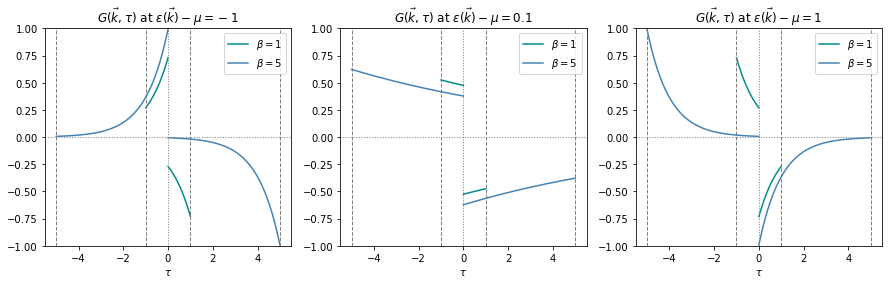

In [66]:
fig, axes = plt.subplots(ncols=3, figsize=(15,4))

beta=10
def f (e,beta):
    return 1/(1+np.exp(beta*e))
def Gtau (tau, ek, beta):
    return -np.exp(-ek*tau) * ( (1-f(ek,beta))*np.heaviside(tau,1) - f(ek,beta)*np.heaviside(-tau,1) )
#def Gtau (tau, ek, beta):
#    return -np.exp(-ek*(tau-beta)) * f(ek,beta)

for ek,ax in zip([-1,0.1,1],axes):
    for beta,color in zip([1,5],['darkcyan','steelblue']):
        tau = np.linspace(-beta,-1e-10,500)
        ax.plot(tau, Gtau(tau, ek, beta), color=color, label=r"$\beta={}$".format(beta))
        tau = np.linspace(1e-10,beta,500)
        ax.plot(tau, Gtau(tau, ek, beta), color=color)
        ax.axvline(x=-beta, linestyle='--', lw=1, color='gray')
        ax.axvline(x=+beta, linestyle='--', lw=1, color='gray')
    ax.axvline(x=0, linestyle='dotted', lw=1, color='gray')
    ax.axhline(y=0, linestyle='dotted', lw=1, color='gray')
    ax.set_title(r"$G(\vec{{k}},\tau)$ at $\epsilon(\vec{{k}})-\mu={}$".format(ek))
    ax.set_ylim((-1,1))
    ax.set_xlabel(r"$\tau$")
    ax.legend()
plt.savefig("green-func-non-interacting.pdf", bbox_inches="tight")

# Unit tests for Green functions

In [30]:
def ωn (β:float, n:int) -> float:
    return (2*n+1)*π / β

def greenmatsubara_time_to_freq (β:float, dτ:float, Gτ:np.array) -> Callable[[int],float]:
    τ = np.arange(0, β, dτ)
    # between 0 and β integrate G(τ) exp(i.ωn.τ)
    f = lambda n: dτ * np.sum( np.exp(1j*ωn(β,n)*τ) * Gτ )
    return np.vectorize(f)

def greenmatsubara_freq_to_time (β:float, Giωn:np.array) -> Callable[[float],float]:
    # Giωn should have an even size 2N, corresponding to n's in [-n,n[ (eg. [-1,0], [-2,-1,0,1]...)
    n = np.arange(-len(Giωn)//2, len(Giωn)//2)
    f = lambda τ: 1/β * np.sum( np.exp(-1j*ωn(β,n)*τ) * Giωn )
    return np.vectorize(f)

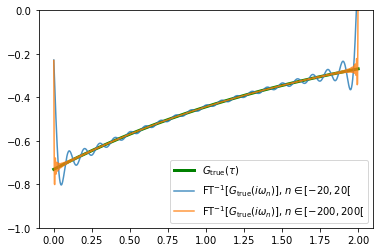

In [85]:
def test_Giωn_1 (β, n, ξ):
    return 1 / ( 1j*ωn(β,n) - ξ )

def test_Gτ_1 (β, τ, ξ):
    return -np.exp(ξ*(β-τ)) / ( np.exp(β*ξ) + 1 )

β = 2
τ = np.linspace(0,β,1000)
dτ = τ[1] - τ[0]
ξ = 0.5

plt.plot( τ, test_Gτ_1(β,τ,ξ), label=r"$G_\operatorname{true}(\tau)$", color='green', lw=3 )
plt.ylim((-1,0))

for ncut in [20,200]:
    n = np.arange(-ncut,ncut)
    test_Gτ_1_tr = greenmatsubara_freq_to_time(β, Giωn=test_Giωn_1(β,n,ξ))
    plt.plot(τ,test_Gτ_1_tr(τ), label=r"$\operatorname{FT}^{-1}[ G_\operatorname{true}(i\omega_n) ]$"+r", $n\in[-{ncut},{ncut}[$".format(ncut=ncut), alpha=0.8)

plt.legend();
#plt.savefig("green-tau-ringing.pdf", bbox_inches='tight')

In [58]:
np.linalg.norm(np.imag(test_Gτ_1_tr(τ)), ord=np.inf)

2.220446049250313e-16

Ok, this is bad. We need to singularize the $1/\mathrm{i}\omega_n$ term.

In [63]:
def greenmatsubara_freq_to_time_sing (β:float, Giωn_sing:np.array) -> Callable[[float],float]:
    # Giωn should have an even size 2N, corresponding to n's in [-n,n[ (eg. [-1,0], [-2,-1,0,1]...)
    n = np.arange(-len(Giωn_sing)//2, len(Giωn_sing)//2)
    f = lambda τ: 1/β * np.sum( np.exp(-1j*ωn(β,n)*τ) * Giωn_sing ) - 1/2
    return np.vectorize(f)

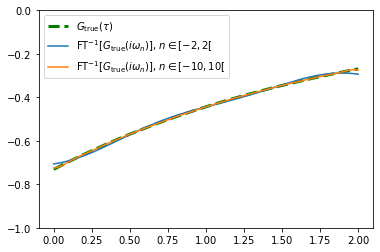

In [87]:
def test_Giωn_1_sing (β, n, ξ):
    iωn = 1j*ωn(β,n)
    return 1/( iωn - ξ ) - 1/iωn

plt.plot( τ, test_Gτ_1(β,τ,ξ), '--', label=r"$G_\operatorname{true}(\tau)$", color='green', lw=3 )
plt.ylim((-1,0))

for ncut in [2, 10]:
    n = np.arange(-ncut,ncut)
    test_Gτ_1_tr = greenmatsubara_freq_to_time_sing(β, test_Giωn_1_sing(β,n,ξ))
    plt.plot(τ,test_Gτ_1_tr(τ), label=r"$\operatorname{FT}^{-1}[ G_\operatorname{true}(i\omega_n) ]$"+r", $n\in[-{ncut},{ncut}[$".format(ncut=ncut))

plt.legend();
#plt.savefig("green-tau-singularized.pdf", bbox_inches='tight')

Muuuuuuuuuuch better. Even $n=2$ works ok !

Now let's check the other way around.